## Part I: Implement and train on Cifar10 dataset a simple baseline for image classification using standard 2D convolutions given the structure below
- conv output channels 64, 64, 128, 128, 128, 256, 256, 256, 512, 512, 512
- kernel shape (3,3)
- strides: 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1
- padding: SAME (snt.SAME)
- num_output_classes = 10


Exercises
   * Fill in the Sonnet module which defined the network.
   * Train the network and see the loss going down. Pay attention to the data augumentation, learning schedule and 
   * To understand how BatchNorm works, remove the update operations and see if the model still trains.

### Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import time

import tensorflow as tf

# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# we will use Sonnet on top of TF 
!pip install -q dm-sonnet
import sonnet as snt

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

Found GPU at: /device:GPU:0


In [0]:
# Reset graph
tf.reset_default_graph()

### Download dataset to be used for training and testing
- Cifar-10 equivalent of MNIST for natural RGB images
- 60000 32x32 colour images in 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- train: 50000; test: 10000

In [0]:
cifar10 = tf.keras.datasets.cifar10
# (down)load dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

156459008/170498071 [==========================>...] - ETA: 3s

170508288/170498071 [==============================] - 44s 0us/step


In [0]:
# Check sizes of tensors
print ('Size of training images')
print (train_images.shape)
print ('Size of training labels')
print (train_labels.shape)
print ('Size of test images')
print (test_images.shape)
print ('Size of test labels')
print (test_labels.shape)

assert train_images.shape[0] == train_labels.shape[0]

Size of training images
(50000, 32, 32, 3)
Size of training labels
(50000, 1)
Size of test images
(10000, 32, 32, 3)
Size of test labels
(10000, 1)


### Display the images

The gallery below shows images from the the data. 

In [0]:
MAX_IMAGES = 10
def gallery(images, label, title='Input images'):  
  class_dict = [u'airplane', u'automobile', u'bird', u'cat', u'deer', u'dog', u'frog', u'horse', u'ship', u'truck']
  num_frames, h, w, num_channels = images.shape
  num_frames = min(num_frames, MAX_IMAGES)
  ff, axes = plt.subplots(1, num_frames,
                          figsize=(num_frames, 1),
                          subplot_kw={'xticks': [], 'yticks': []})
  for i in range(0, num_frames):
    if num_channels == 3:
      axes[i].imshow(np.squeeze(images[i]))
    else:
      axes[i].imshow(np.squeeze(images[i]), cmap='gray')
    axes[i].set_title(class_dict[label[i][0]])
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)
  ff.subplots_adjust(wspace=0.1)
  plt.show()
  

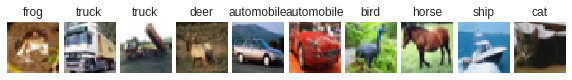

In [0]:
gallery(train_images, train_labels)

### Prepare the data for training and testing
- for training, we use stochastic optimizers (e.g. SGD, Adam), so we need to sample at random mini-batches from the training dataset
- for testing, we iterate sequentially through the test set

In [0]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 32 #@param
BATCH_SIZE_TEST = 100 #@param

# create Dataset objects using the data previously downloaded
dataset_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# we shuffle the data and sample repeatedly batches for training
batched_dataset_train = dataset_train.shuffle(100000).repeat().batch(BATCH_SIZE_TRAIN)
# create iterator to retrieve batches
iterator_train = batched_dataset_train.make_one_shot_iterator()
# get a training batch of images and labels
(batch_train_images, batch_train_labels) = iterator_train.get_next()

# check that the shape of the training batches is the expected one
print ('Shape of training images')
print (batch_train_images)
print ('Shape of training labels')
print (batch_train_labels)

Shape of training images
Tensor("IteratorGetNext:0", shape=(?, 32, 32, 3), dtype=uint8)
Shape of training labels
Tensor("IteratorGetNext:1", shape=(?, 1), dtype=uint8)


In [0]:
# we do the same for test dataset
dataset_test = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
batched_dataset_test = dataset_test.repeat().batch(BATCH_SIZE_TEST)
iterator_test = batched_dataset_test.make_one_shot_iterator() 
(batch_test_images, batch_test_labels) = iterator_test.get_next()
print ('Shape of test images')
print (batch_test_images)
print ('Shape of test labels')
print (batch_test_labels)

batch_test_labels = tf.cast(tf.squeeze(batch_test_labels), tf.int32)
batch_train_labels = tf.cast(tf.squeeze(batch_train_labels), tf.int32)

Shape of test images
Tensor("IteratorGetNext_1:0", shape=(?, 32, 32, 3), dtype=uint8)
Shape of test labels
Tensor("IteratorGetNext_1:1", shape=(?, 1), dtype=int64)


In [0]:
# preprocess input for training and testing
def random_flip_left_right(image, flip_index, seed=None):
  shape = image.get_shape()
  if shape.ndims == 3 or shape.ndims is None:
    uniform_random = tf.random_uniform([], 0, 1.0, seed=seed)
    mirror_cond = tf.less(uniform_random, .5)
    result = tf.cond(
        mirror_cond,
        lambda: tf.reverse(image, [flip_index]),
        lambda: image
    )
    return result
  elif shape.ndims == 4:
    uniform_random = tf.random_uniform(
        [tf.shape(image)[0]], 0, 1.0, seed=seed
    )
    mirror_cond = tf.less(uniform_random, .5)
    return tf.where(
        mirror_cond,
        image,
        tf.map_fn(lambda x: tf.reverse(x, [flip_index]), image, dtype=image.dtype)
    )
  else:
    raise ValueError("\'image\' must have either 3 or 4 dimensions.")
    
def train_image_preprocess(h, w, random_flip=True):
  """Image processing required for training the model."""

  def fn(image):
    # Ensure the data is in range [-1, 1].
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = image * 2.0 - 1.0
    # Randomly choose a (24, 24, 3) patch to be used for training.
    image = tf.random_crop(image, size=(BATCH_SIZE_TRAIN, h, w, 3))
    # Randomly flip the image.
    image = random_flip_left_right(image, 2)
    return image

  return fn

def test_image_preprocess():
  def fn(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = image * 2.0 - 1.0
    return image
  return fn

### Define the network 

Note: the network should output the last layer logits, not the probabilities.

In [0]:
class Baseline(snt.AbstractModule):
  
  def __init__(self, num_classes, name="baseline"):
    super(Baseline, self).__init__(name=name)
    
    #############
    #           #
    # YOUR CODE #
    #           #
    #############
   
  def _build(self, inputs, is_training=None, test_local_stats=False):
    
    #############
    #           #
    # YOUR CODE #
    #           #
    #############

    return logits

### Number of Parameters
What this is total number of parameters of the model below? Check your computation by retrieving the trainable_variables.

In [0]:
def get_num_params(scope):
  total_parameters = 0
  for variable in tf.trainable_variables(scope):
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
      variable_parameters *= dim.value
    total_parameters += variable_parameters
  return total_parameters

### Connect the Sonnet module to the data 


In [0]:
# First define the preprocessing ops for the train/test data
crop_height = 24 #@param
cropt_width = 24 #@param
preprocess_fn_train = train_image_preprocess(crop_height, cropt_width)
preprocess_fn_test = test_image_preprocess()

num_classes = 10 #@param

In [0]:
# Instantiate the model
with tf.variable_scope("baseline"):
  baseline_model = Baseline(num_classes)

In [0]:
# get predictions from the model
train_predictions = baseline_model(preprocess_fn_train(batch_train_images), is_training=True)
print (train_predictions)

test_predictions = baseline_model(preprocess_fn_test(batch_test_images), is_training=False)
print (test_predictions)
print ("Total number of parameters of simple model")
print (get_num_params("baseline"))


Tensor("baseline_1/linear/add:0", shape=(32, 10), dtype=float32)
Tensor("baseline_2/linear/add:0", shape=(?, 10), dtype=float32)
Total number of parameters of simple model
7790794


### Define the loss to be minimized during training

In [0]:
def get_loss(logits=None, labels=None):
  # We reduce over batch dimension, to ensure the loss is a scalar.   
  return tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=labels, logits=logits))

In [0]:
# Define train and test loss functions
train_loss = get_loss(labels=batch_train_labels, logits=train_predictions)
test_loss = get_loss(labels=batch_test_labels, logits=test_predictions)

In [0]:
# for evaluation, we look at top_k_accuracy since it's easier to interpret; normally k=1 or k=5
def top_k_accuracy(k, labels, logits):
  in_top_k = tf.nn.in_top_k(predictions=tf.squeeze(logits), targets=labels, k=k)
  return tf.reduce_mean(tf.cast(in_top_k, tf.float32))

### Create the optimizer

We will use the Momentum optimizer, but other optimizers such as Adam or AdaGrad can be used. 

In [0]:
def get_optimizer(step):
  """Get the optimizer used for training."""
  lr_schedule = (40e3, 60e3, 80e3)
  lr_schedule = tf.to_int64(lr_schedule)
  lr_factor = 0.1
  
  lr_init = 0.1
  num_epochs = tf.reduce_sum(tf.to_float(step >= lr_schedule))
  lr = lr_init * lr_factor**num_epochs

  return tf.train.MomentumOptimizer(learning_rate=lr, momentum=0.9)

### Set up the training

In [0]:
# Create a global step that is incremented during training; useful for e.g. learning rate annealing
global_step = tf.train.get_or_create_global_step()

# instantiate the optimizer
optimizer = get_optimizer(global_step)

### Create the update ops

Batch normalization requires updating the moving running averages. To ensure that TensorFlow runs the update ops, we have to manually create an operation which encompasses all the updates. 

The Sonnet BatchNorm module ensures that the moving average updates are added to the global UPDATE_OPS collections. To find out more about collections: https://www.tensorflow.org/api_guides/python/framework#Graph_collections

In [0]:
# Get training ops
training_baseline_op = optimizer.minimize(train_loss, global_step)

update_ops = tf.group(*tf.get_collection(tf.GraphKeys.UPDATE_OPS))
training_baseline_op = tf.group(training_baseline_op, update_ops)

In [0]:
# Get test ops
test_acc_baseline_op = top_k_accuracy(1, batch_test_labels, test_predictions)

In [0]:
# Write a function that takes a list of losses and plots them.
def plot_losses(loss_list, steps):
  display.clear_output(wait=True)
  display.display(pl.gcf())
  pl.plot(steps, loss_list, c='b')
  time.sleep(1.0)

In [0]:
# Create the session and initialize variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Train the model



In [0]:
# Define number of training iterations and reporting intervals
TRAIN_ITERS = 90e3 #@param
REPORT_TRAIN_EVERY = 10 #@param
PLOT_EVERY = 500 #@param
REPORT_TEST_EVERY = 1000 #@param
TEST_ITERS = 10 #@param


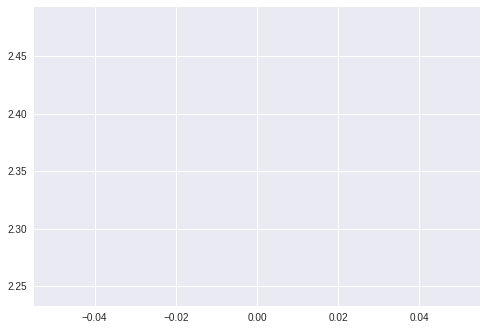

KeyboardInterrupt: ignored

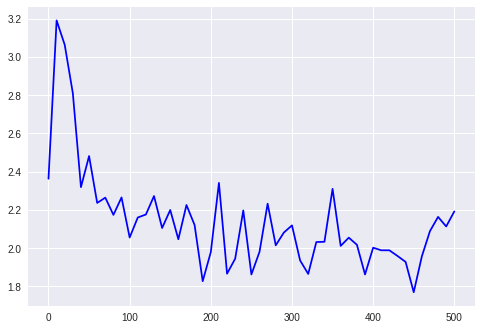

In [0]:
train_iter = 0
losses = []
steps = []
for train_iter in range(int(TRAIN_ITERS)):
  _, train_loss_np = sess.run([training_baseline_op, train_loss])
  
  if (train_iter % REPORT_TRAIN_EVERY) == 0:
    losses.append(train_loss_np)
    steps.append(train_iter)
  if (train_iter % PLOT_EVERY) == 0:
    plot_losses(losses, steps)    
    
  if (train_iter % REPORT_TEST_EVERY) == 0:
    avg_acc = 0.0
    for test_iter in range(TEST_ITERS):
      acc = sess.run(test_acc_baseline_op)
      avg_acc += acc
      
    avg_acc /= (TEST_ITERS)
    print ('Test acc at iter {0:5d} out of {1:5d} is {2:.2f}%'.format(int(train_iter), int(TRAIN_ITERS), avg_acc*100.0))